In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import researchpy

import statsmodels.api as sm
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy

## Import Data

In [2]:
cpu = pd.read_csv('data/CPU.csv', index_col=0)
survey = pd.read_csv('data/BAMA511_ CPU Rankings.csv', index_col='ResponseId')
survey2 = survey.iloc[:, 16:].dropna()
survey2.columns = ['CPU1','CPU2','CPU3','CPU4','CPU5','CPU6','CPU7','CPU8','CPU9']
survey_merge = survey2.melt()

survey_merge = survey_merge.merge(cpu, left_on = 'variable', right_index = True).drop('variable', axis=1)
survey_merge = sm.add_constant(survey_merge)

In [17]:
cpu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, CPU1 to CPU9
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price_Med    9 non-null      int64
 1   Price_High   9 non-null      int64
 2   Brand_AMD    9 non-null      int64
 3   Brand_Intel  9 non-null      int64
 4   Score_Med    9 non-null      int64
 5   Score_High   9 non-null      int64
 6   Release_01   9 non-null      int64
 7   Release_12   9 non-null      int64
dtypes: int64(8)
memory usage: 648.0+ bytes


In [18]:
cpu.head()

,Price_Med,Price_High,Brand_AMD,Brand_Intel,Score_Med,Score_High,Release_01,Release_12
CPU,,,,,,,,
CPU1,0,0,0,1,0,0,1,0
CPU2,0,0,1,0,1,0,0,1
CPU3,0,0,0,0,0,1,0,0
CPU4,1,0,0,1,1,0,0,0
CPU5,1,0,1,0,0,1,1,0


In [3]:
result = sm.OLS(survey_merge['value'],survey_merge.drop('value', axis=1)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     39.03
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           5.24e-49
Time:                        22:08:59   Log-Likelihood:                -1174.5
No. Observations:                 549   AIC:                             2367.
Df Residuals:                     540   BIC:                             2406.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.2186      0.265     23.437      

In [4]:
res_df = pd.DataFrame(result.params, columns=['Coef'])
res_df = res_df.merge(pd.DataFrame(result.tvalues, columns=['t-stat']), left_index = True, right_index=True)
res_df =  res_df.merge(result.conf_int(), left_index = True, right_index=True)
res_df.columns = ['coef', 't-stat', '2.5% Confint', '97.5% Confint']
res_df.to_csv('RegResult.csv')

# Cluster Analysis

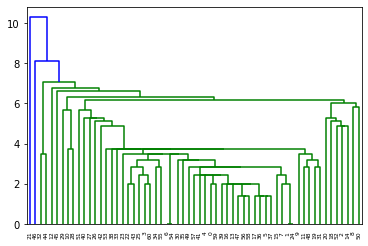

In [5]:
# Use linkage and dendrogram function to generate cluster dendrogram
# Output from dendrogram is inconclusive
Z = hierarchy.linkage(np.array(survey2),'single')
dn = hierarchy.dendrogram(Z)

In [6]:
# Populate entry for elbow plot using .inertia_ to measure SSD of points from cluster centroid
dist_list = []
clust_list = [i for i in range(1,11)]

for i in clust_list: 
    kmeans = KMeans(n_clusters=i, random_state=0).fit(survey2)
    dist_list.append(kmeans.inertia_)

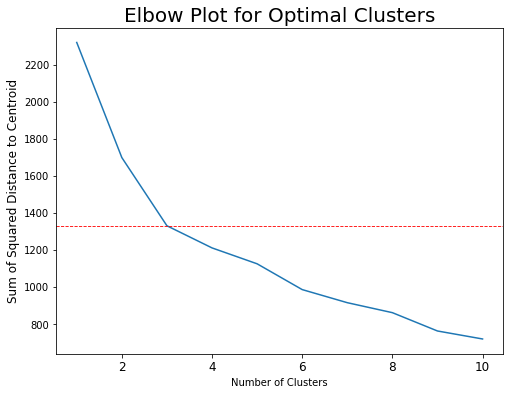

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(x=clust_list, y=dist_list, markers = True)

ax.axhline(dist_list[2], linestyle='--', color='red', linewidth=0.85)
ax.set_title('Elbow Plot for Optimal Clusters', fontsize=20)
ax.set_xlabel('Number of Clusters', fontsize=10)
ax.set_ylabel('Sum of Squared Distance to Centroid', fontsize=12)
ax.tick_params(axis='x', labelsize=12)

Based on the elbow plot, the number of clusters that leads to optimal reduction of Within Group Sum of Sqaure seems to be.  Hence, we will proceed with K-mean clustering with 3 centroids.

In [8]:
# Perform K-Mean Clustering with Optimal Clusters
kmeans = KMeans(n_clusters=3, random_state=0).fit(survey2)
survey2['cluster'] = kmeans.labels_

# Groupby average ranking of each cluster  Generate result in new df
clust_res = survey2.groupby('cluster').mean().round(2)
clust_res = clust_res.merge(survey2.groupby('cluster').count().filter(items = ['CPU1']).rename(columns = {'CPU1':'num_obs'}),
                           left_index = True, 
                           right_index =True)

clust_res

,CPU1,CPU2,CPU3,CPU4,CPU5,CPU6,CPU7,CPU8,CPU9,num_obs
cluster,,,,,,,,,,
0,4.20,5.40,8.13,3.33,3.60,5.67,3.07,5.33,6.27,15
1,6.13,2.87,2.96,4.57,2.52,7.04,3.74,8.57,6.61,23
2,2.39,1.70,3.09,4.30,3.96,5.87,7.04,8.48,8.17,23


In [9]:
# Merge individual clusters with CPU characteristic df to generate preferred characteristic for each cluster
survey_long = survey2.reset_index().melt(id_vars='ResponseId')
survey_long = survey_long.merge(cpu, left_on = 'variable', right_index = True).drop('variable', axis=1).set_index('ResponseId')
survey_long = survey_long.merge(survey2.filter(items = ['cluster']), left_index = True, right_index = True)
survey_long.to_csv('cluster_res.csv')

# Keep only top/bottom preferred CPU to consider CPU characteristic by cluster
# Preferred characteristic of top most preferred CPU by cluster
survey_long.loc[survey_long['value'] == 1].groupby('cluster').mean().round(2)

,value,Price_Med,Price_High,Brand_AMD,Brand_Intel,Score_Med,Score_High,Release_01,Release_12
cluster,,,,,,,,,
0,1.0,0.53,0.27,0.20,0.73,0.53,0.33,0.33,0.27
1,1.0,0.39,0.17,0.61,0.17,0.22,0.78,0.39,0.39
2,1.0,0.13,0.00,0.48,0.43,0.52,0.13,0.39,0.43


In [10]:
# Preferred characteristic of least preferred CPU by cluster
survey_long.loc[survey_long['value'] == 9].groupby('cluster').mean().round(2)

,value,Price_Med,Price_High,Brand_AMD,Brand_Intel,Score_Med,Score_High,Release_01,Release_12
cluster,,,,,,,,,
0,9.0,0.07,0.33,0.07,0.00,0.33,0.67,0.40,0.00
1,9.0,0.13,0.83,0.74,0.04,0.09,0.00,0.13,0.13
2,9.0,0.00,1.00,0.52,0.04,0.43,0.04,0.43,0.04


In [11]:
best_filter = survey_long['value'] == 1
char_list = survey_long.columns[1: len(survey_long.columns)-1]
res_dict = {'characteristic':[], 'Chi-Sq Stat': [], 'p-value': [], 'pct_clust1':[], 'pct_clust2':[], 'pct_clust3':[], 'pct_avg':[]}

for i in char_list:
    cross1 = researchpy.crosstab(survey_long[best_filter]['cluster'], survey_long[best_filter][i], prop = 'row', test = "chi-square")
    res_dict['characteristic'].append(i)
    res_dict['Chi-Sq Stat'].append(cross1[1].iloc[0].values[1])
    res_dict['p-value'].append(cross1[1].iloc[1].values[1])
    res_dict['pct_clust1'].append(cross1[0].iloc[0].values[1].round(2))
    res_dict['pct_clust2'].append(cross1[0].iloc[1].values[1].round(2))
    res_dict['pct_clust3'].append(cross1[0].iloc[2].values[1].round(2))
    res_dict['pct_avg'].append(cross1[0].iloc[3].values[1].round(2))

crosstab_best = pd.DataFrame(res_dict)
crosstab_best

,characteristic,Chi-Sq Stat,p-value,pct_clust1,pct_clust2,pct_clust3,pct_avg
0,Price_Med,7.3618,0.0252,53.33,39.13,13.04,32.79
1,Price_High,6.2585,0.0438,26.67,17.39,0.00,13.11
2,Brand_AMD,6.1620,0.0459,20.00,60.87,47.83,45.90
3,Brand_Intel,11.8421,0.0027,73.33,17.39,43.48,40.98
4,Score_Med,5.6584,0.0591,53.33,21.74,52.17,40.98
5,Score_High,20.7025,0.0000,33.33,78.26,13.04,42.62
6,Release_01,0.1618,0.9223,33.33,39.13,39.13,37.70
7,Release_12,1.1244,0.5700,26.67,39.13,43.48,37.70


In [12]:
worst_filter = survey_long['value'] == 9
char_list = survey_long.columns[1: len(survey_long.columns)-1]
res_dict2 = {'characteristic':[], 'Chi-Sq Stat': [], 'p-value': [], 'pct_clust1':[], 'pct_clust2':[], 'pct_clust3':[], 'pct_avg':[]}

for i in char_list:
    cross1 = researchpy.crosstab(survey_long[worst_filter]['cluster'], survey_long[worst_filter][i], prop = 'row', test = "chi-square")
    res_dict2['characteristic'].append(i)
    res_dict2['Chi-Sq Stat'].append(cross1[1].iloc[0].values[1])
    res_dict2['p-value'].append(cross1[1].iloc[1].values[1])
    res_dict2['pct_clust1'].append(cross1[0].iloc[0].values[1].round(2))
    res_dict2['pct_clust2'].append(cross1[0].iloc[1].values[1].round(2))
    res_dict2['pct_clust3'].append(cross1[0].iloc[2].values[1].round(2))
    res_dict2['pct_avg'].append(cross1[0].iloc[3].values[1].round(2))

crosstab_worst = pd.DataFrame(res_dict2)
crosstab_worst

,characteristic,Chi-Sq Stat,p-value,pct_clust1,pct_clust2,pct_clust3,pct_avg
0,Price_Med,3.1935,0.2026,6.67,13.04,0.00,6.56
1,Price_High,23.4638,0.0000,33.33,82.61,100.00,77.05
2,Brand_AMD,16.5591,0.0003,6.67,73.91,52.17,49.18
3,Brand_Intel,0.6743,0.7138,0.00,4.35,4.35,3.28
4,Score_Med,7.2167,0.0271,33.33,8.70,43.48,27.87
5,Score_High,31.9772,0.0000,66.67,0.00,4.35,18.03
6,Release_01,5.6939,0.0580,40.00,13.04,43.48,31.15
7,Release_12,2.8150,0.2448,0.00,13.04,4.35,6.56


## Cluster Conjoint

Generating regression result for each of the clusters to examine the effect of product characteristics on ranking.   Equation below is defined with ranking as the target variable and product 

$Ranking_{i,j} = \beta_{0,j} +  \beta_{1,j}PriceMed_{i,j} +  \beta_{2,j}PriceHigh_{i,j} +  \beta_{3,j}RankingMed_{i,j} + .... + \epsilon_{i,j}$

In [13]:
survey_merge2 = survey2.melt(id_vars='cluster').merge(cpu, left_on = 'variable', right_index = True).drop('variable', axis=1)
survey_merge2 = sm.add_constant(survey_merge2)
clust1 = survey_merge2.loc[survey_merge2['cluster']==0]
clust2 = survey_merge2.loc[survey_merge2['cluster']==1]
clust3 = survey_merge2.loc[survey_merge2['cluster']==2]

In [14]:
result_clust1 = sm.OLS(clust1['value'],clust1.drop(['cluster','value'], axis=1)).fit()
print(result_clust1.summary())

res_df_clust1 = pd.DataFrame(result_clust1.params.round(2), columns=['Coef'])
res_df_clust1 = res_df_clust1.merge(pd.DataFrame(result_clust1.tvalues.round(2), columns=['t-stat']), left_index = True, right_index=True)
res_df_clust1 =  res_df_clust1.merge(result_clust1.conf_int().round(2), left_index = True, right_index=True)
res_df_clust1.columns = ['coef', 't-stat', '2.5% Confint', '97.5% Confint']
res_df_clust1.to_csv('RegResult_clust1.csv')

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     8.639
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           2.41e-09
Time:                        22:09:02   Log-Likelihood:                -290.09
No. Observations:                 135   AIC:                             598.2
Df Residuals:                     126   BIC:                             624.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.2667      0.555     14.907      

In [15]:
result_clust2 = sm.OLS(clust2['value'],clust2.drop(['cluster','value'], axis=1)).fit()
print(result_clust2.summary())

res_df_clust2 = pd.DataFrame(result_clust2.params.round(2), columns=['Coef'])
res_df_clust2 = res_df_clust2.merge(pd.DataFrame(result_clust2.tvalues.round(2), columns=['t-stat']), left_index = True, right_index=True)
res_df_clust2 =  res_df_clust2.merge(result_clust2.conf_int().round(2), left_index = True, right_index=True)
res_df_clust2.columns = ['coef', 't-stat', '2.5% Confint', '97.5% Confint']
res_df_clust2.to_csv('RegResult_clust2.csv')

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     40.92
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           4.68e-38
Time:                        22:09:02   Log-Likelihood:                -389.07
No. Observations:                 207   AIC:                             796.1
Df Residuals:                     198   BIC:                             826.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.1304      0.338     21.100      

In [16]:
result_clust3 = sm.OLS(clust3['value'],clust3.drop(['cluster','value'], axis=1)).fit()
print(result_clust3.summary())

res_df_clust3 = pd.DataFrame(result_clust3.params.round(2), columns=['Coef'])
res_df_clust3 = res_df_clust3.merge(pd.DataFrame(result_clust3.tvalues.round(2), columns=['t-stat']), left_index = True, right_index=True)
res_df_clust3 =  res_df_clust3.merge(result_clust3.conf_int().round(2), left_index = True, right_index=True)
res_df_clust3.columns = ['coef', 't-stat', '2.5% Confint', '97.5% Confint']
res_df_clust3.to_csv('RegResult_clust3.csv')


                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     124.7
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           5.05e-73
Time:                        22:09:02   Log-Likelihood:                -304.00
No. Observations:                 207   AIC:                             626.0
Df Residuals:                     198   BIC:                             656.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.9710      0.224     17.724      